## Fruits recognition

### Import all the Dependencies

In [1]:
import tensorflow as tf # Import TensorFlow library and specific modules
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt # Import matplotlib for visualization

#### Set constant

In [3]:
BATCH_SIZE = 32  # Specify the batch size
IMAGE_SIZE = 280 # Specify the desired image size
CHANNELS=3 #Number of color channels in the images (3 for RGB)
EPOCHS=40 #Iterations through dataset


#### Import fruits data into tensorflow dataset object & Mount google drive to fetch file



In [4]:
from google.colab import drive
drive.mount('/content/gdrive') #mounting google drive to pull resources from it
dataset_path = '/content/gdrive/MyDrive/AI/fruitsdataset' #path to the dataset

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/gdrive/MyDrive/AI/fruitsdataset/train',

    seed=123,     # Specify a seed for reproducibility
    shuffle=True, # Whether to shuffle the dataset
    image_size=(IMAGE_SIZE,IMAGE_SIZE), #used as specified on the upper block
    batch_size=BATCH_SIZE               #used as specified on the upper block
)

Mounted at /content/gdrive
Found 1212 files belonging to 6 classes.


In [5]:
class_names = dataset.class_names #Class names
class_names

['freshapples',
 'freshbanana',
 'freshoranges',
 'rottenapples',
 'rottenbanana',
 'rottenoranges']

In [6]:
for image_batch, labels_batch in dataset.take(1): # Loop over the first batch of the dataset
    print(image_batch.shape) # Print the shape of the image batch
    print(labels_batch.numpy()) # Print the corresponding labels batch in numpy format

(32, 280, 280, 3)
[3 3 0 1 5 0 3 4 3 5 4 5 5 0 1 3 1 1 1 4 0 1 5 2 2 2 4 1 1 3 0 5]


Each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels

### Visualize some of the images from our dataset

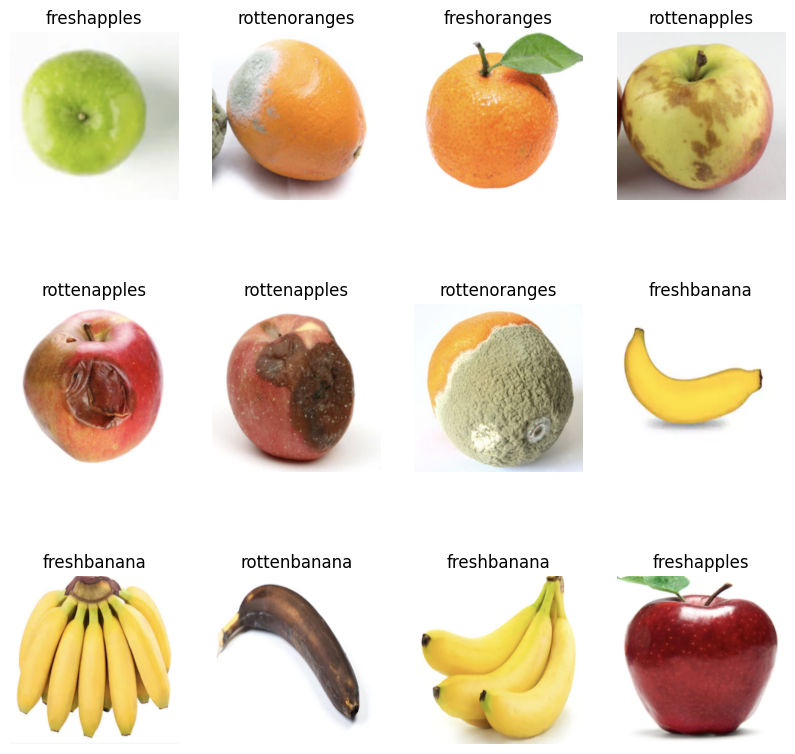

In [7]:
plt.figure(figsize=(10, 10)) #Size for Visualized Figures
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1) #Plotting 12 images in  3 rows by 4 columns format
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]]) #Titles of fruits
        plt.axis("off") #Axis hidden for clearer visuals

### Function to Split Dataset
Dataset should be bifurcated into 3 subsets, namely:
<br>
**Training**: Dataset to be used while training <br>
**Validation**: Dataset to be tested against while training<br>
**Test**: Dataset to be tested against after we trained a model<br>

In [8]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1 #dataset split, 80% for trainning and 10% each for validation & test

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [9]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [10]:
len(train_ds)

30

In [11]:
len(val_ds)

3

In [12]:
len(test_ds)

5

### Cache, Shuffle, and Prefetch the Dataset

## Cache, shuffle, and prefetch operations for training dataset

# Cache, shuffle, and prefetch operations for training dataset


In [13]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) # Cache the dataset in memory for faster access during training
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) # Shuffle the dataset to introduce randomness during training
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) # Prefetch batches to overlap data preprocessing and model execution

### Building the Model

#### Creating a Layer for Resizing and Normalization

Before we feed our images to network, we resize it to the desired size.

This will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [14]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

#### Data Augmentation


Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.
Random rotation function is used.

In [15]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

#### Applying Data Augmentation to Train Dataset

In [16]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

### Model Architecture

We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.



In [17]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 6

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 280, 280, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 278, 278, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 139, 139, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 137, 137, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 68, 68, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 66, 66, 64)         

#### Compiling the Model

We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [19]:
model.compile(
    optimizer='adam',   # Use the Adam optimizer for gradient-based optimization
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), # Sparse categorical crossentropy loss function
    metrics=['accuracy'] # Track accuracy as a metric during training
)

In [20]:
history = model.fit(
    train_ds, # Training dataset
    batch_size=BATCH_SIZE, # Specify the batch size for training
    validation_data=val_ds, # Validation dataset for monitoring performance during training
    verbose=1, # Verbosity level (1: progress bar, 0: silent)
    epochs=40, # Number of training epochs..the number of iterations through dataset in training phase
)

Epoch 1/40
30/30 [==============================] - 271s 6s/step - loss: 1.7608 - accuracy: 0.2521 - val_loss: 1.7306 - val_accuracy: 0.1771
Epoch 2/40
30/30 [==============================] - 170s 6s/step - loss: 1.3968 - accuracy: 0.4446 - val_loss: 1.3354 - val_accuracy: 0.4479
Epoch 3/40
30/30 [==============================] - 174s 6s/step - loss: 1.0770 - accuracy: 0.5690 - val_loss: 0.8360 - val_accuracy: 0.6667
Epoch 4/40
30/30 [==============================] - 164s 5s/step - loss: 0.8181 - accuracy: 0.6872 - val_loss: 0.7604 - val_accuracy: 0.7812
Epoch 5/40
30/30 [==============================] - 163s 5s/step - loss: 0.6953 - accuracy: 0.7437 - val_loss: 0.7450 - val_accuracy: 0.7500
Epoch 6/40
30/30 [==============================] - 163s 5s/step - loss: 0.6605 - accuracy: 0.7741 - val_loss: 0.4674 - val_accuracy: 0.8438
Epoch 7/40
30/30 [==============================] - 163s 5s/step - loss: 0.5987 - accuracy: 0.7866 - val_loss: 0.4494 - val_accuracy: 0.8542
Epoch 8/40
30

In [27]:
scores = model.evaluate(test_ds)

5/5 [==============================] - 20s 1s/step - loss: 0.4452 - accuracy: 0.8813


we get 88% accuracy for our test dataset.

In [28]:
scores

[0.4451647400856018, 0.8812500238418579]

list containing loss and accuracy value

### Plotting the Accuracy and Loss Curves

In [29]:
history

In [30]:
history.params

{'verbose': 1, 'epochs': 40, 'steps': 30}

In [31]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch

In [32]:
type(history.history['loss'])

list

In [33]:
len(history.history['loss'])

40

In [34]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.6773955821990967,
 1.3698546886444092,
 1.1837214231491089,
 0.9194394946098328,
 0.9104592204093933]

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

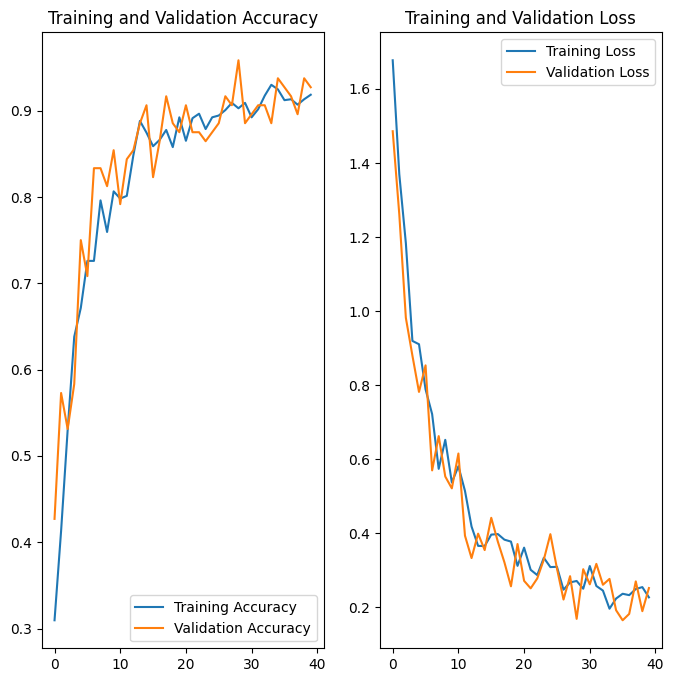

In [36]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Run prediction on a sample image

first image to predict
actual label: rottenoranges
1/1 [==============================] - 1s 1s/step
predicted label: rottenoranges


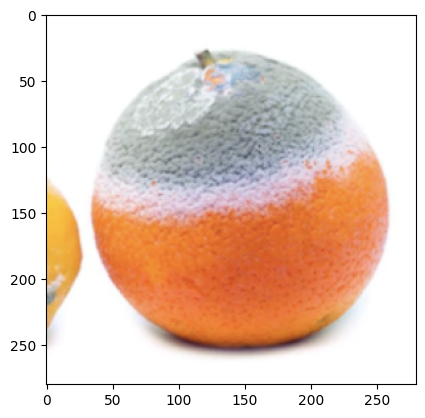

In [37]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

#### inference Function

In [38]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

Running inference on few sample imagesNow run inference on few sample images

1/1 [==============================] - 0s 54ms/step


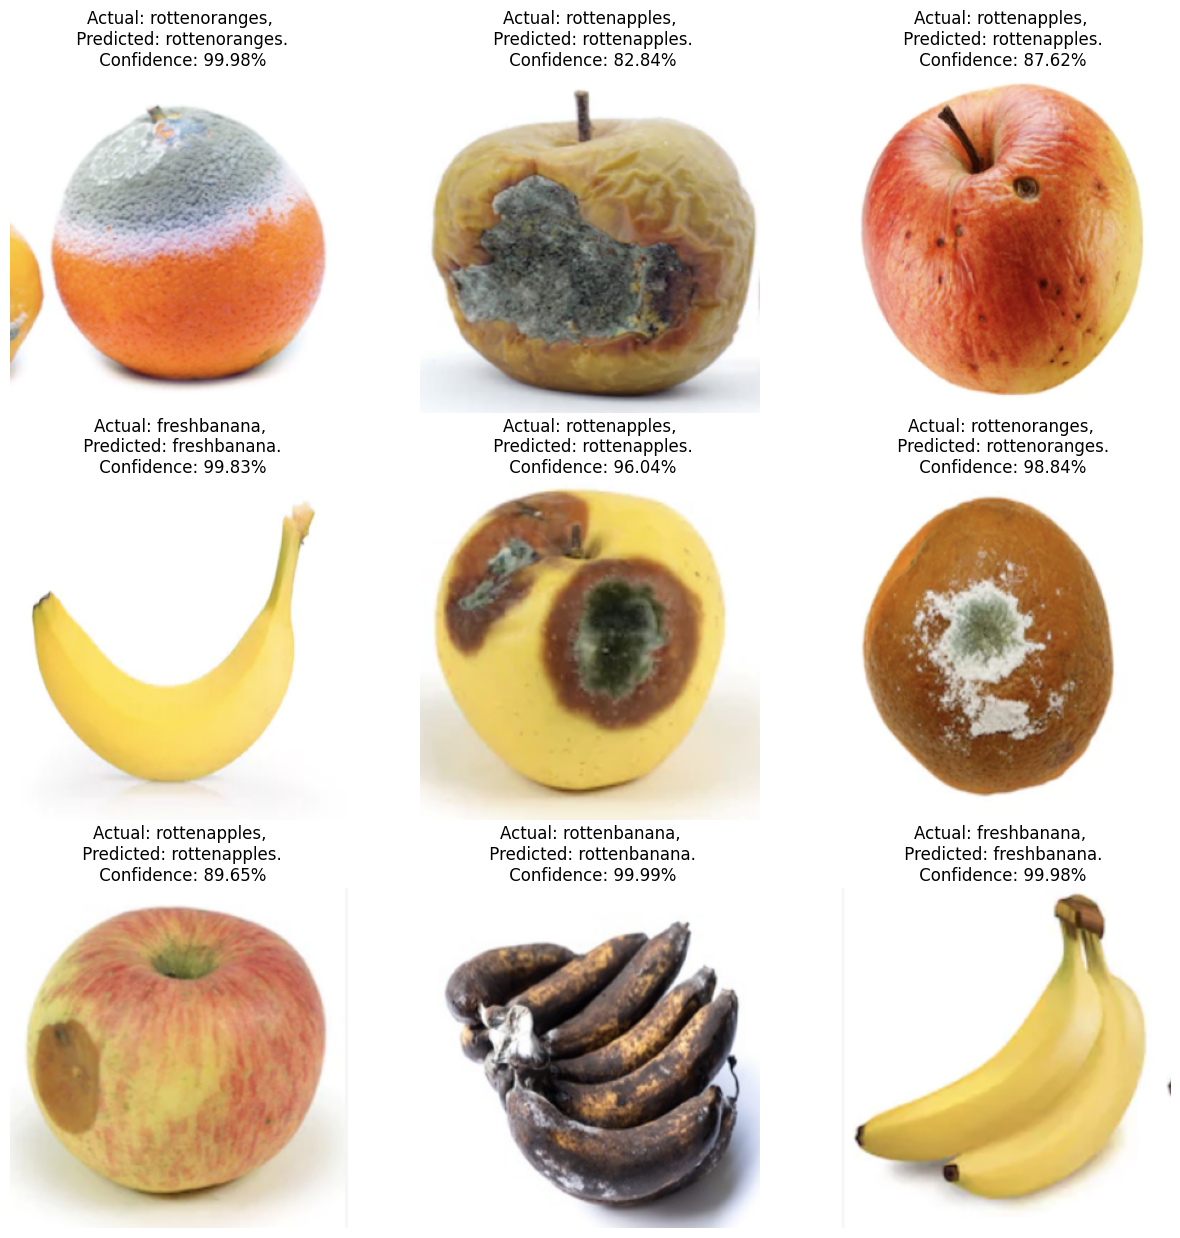

In [39]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1) #3 rows by 3 columns
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

#### Saving the Model

In [22]:
model.save('/content/gdrive/MyDrive/AI/perishables.ipynb')